## Isolation Forest Model for Anomaly Detection

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.


In [1]:
import numpy as np
import pandas as pd
##import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')  # prettier plots

import sklearn
from scipy.special import comb

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Import model data

In [2]:
data_raw = pd.read_csv('model_data.csv')

In [3]:
data_raw.head()

,Unnamed: 0,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn,n_days_gt10_l30d,avg_bal_gt10_l30d
0,1,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0,22,80.800000
1,2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0,22,387.156364
2,3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0,22,49.240000
3,4,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0,22,191.885000
4,5,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0,22,162.414545


In [21]:
data_train = data_raw.drop(['Unnamed: 0','user_id', 'churn'], axis=1)

In [5]:
data_train.shape

(5584, 11)

In [9]:
data_train.dtypes

risk_tolerance                   object
investment_experience            object
liquidity_needs                  object
platform                         object
time_spent                      float64
instrument_type_first_traded     object
first_deposit_amount            float64
time_horizon                     object
churn                             int64
n_days_gt10_l30d                  int64
avg_bal_gt10_l30d               float64
dtype: object

### One Hot Encoding

In [22]:
cat_cols = []
for c in data_train.columns:
    if data_train[c].dtype =='object' or data_train[c].dtype == 'bool':
        cat_cols.append(c)

In [12]:
print(cat_cols)

['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 'instrument_type_first_traded', 'time_horizon']


In [23]:
### OneHot Encoding for Categorical features
X = pd.get_dummies(data_train, columns = cat_cols)
X.head()

,time_spent,first_deposit_amount,n_days_gt10_l30d,avg_bal_gt10_l30d,risk_tolerance_high_risk_tolerance,risk_tolerance_low_risk_tolerance,risk_tolerance_med_risk_tolerance,investment_experience_extensive_investment_exp,investment_experience_good_investment_exp,investment_experience_limited_investment_exp,...,instrument_type_first_traded_lp,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,time_horizon_long_time_horizon,time_horizon_med_time_horizon,time_horizon_short_time_horizon
0,33.129417,40.0,22,80.800000,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,16.573517,200.0,22,387.156364,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,10.008367,25.0,22,49.240000,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,1.031633,100.0,22,191.885000,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,8.187250,20.0,22,162.414545,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


### Isolation forest model - returns scores of test data points (- anomaly, + normal)

In [24]:
%%time
clf = IsolationForest(n_estimators=100, max_samples=99,random_state=999, contamination=0.05, n_jobs=1)
clf.fit(X)
scores = clf.decision_function(X)

CPU times: user 481 ms, sys: 37 ms, total: 518 ms
Wall time: 517 ms


(5584,)
(5584, 31)


(array([  1.,   0.,   0.,   1.,   3.,   1.,   0.,   3.,   4.,  10.,  15.,
         16.,  21.,  15.,  27.,  35.,  39.,  51.,  61.,  67.,  81., 109.,
        112., 121.,  99., 134., 147., 149., 171., 206., 193., 216., 208.,
        180., 199., 237., 288., 301., 270., 195., 235., 179., 239., 192.,
        160.,  46.,  92., 175.,  90., 190.]),
 array([-0.13702991, -0.13173965, -0.1264494 , -0.12115915, -0.1158689 ,
        -0.11057865, -0.1052884 , -0.09999814, -0.09470789, -0.08941764,
        -0.08412739, -0.07883714, -0.07354689, -0.06825663, -0.06296638,
        -0.05767613, -0.05238588, -0.04709563, -0.04180538, -0.03651512,
        -0.03122487, -0.02593462, -0.02064437, -0.01535412, -0.01006387,
        -0.00477361,  0.00051664,  0.00580689,  0.01109714,  0.01638739,
         0.02167764,  0.0269679 ,  0.03225815,  0.0375484 ,  0.04283865,
         0.0481289 ,  0.05341915,  0.05870941,  0.06399966,  0.06928991,
         0.07458016,  0.07987041,  0.08516066,  0.09045092,  0.09574117,
 

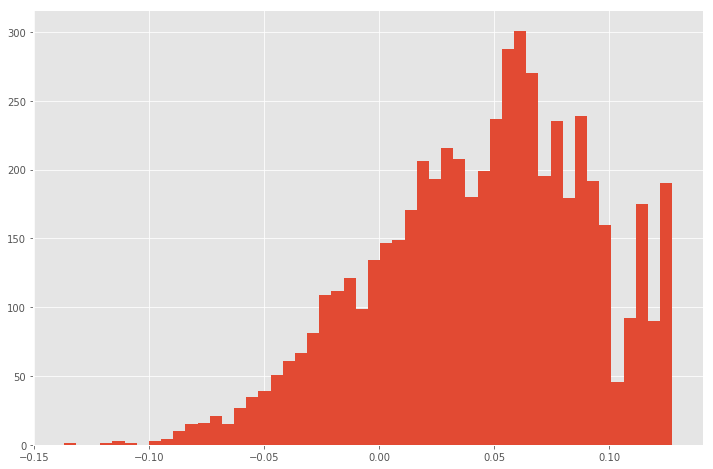

In [25]:
### Distribution of scores
print(scores.shape)
print(X.shape)
plt.figure(figsize=(12, 8))
plt.hist(scores, bins=50)

In [26]:
X_scores = X.copy()
threshold = -0.05 ## how do you decide threshold
print(X.shape)
X_scores['scores'] = scores
print(X_scores.shape)

(5584, 31)
(5584, 32)


In [31]:
data_raw['score'] = X_scores['scores']
data_raw['anomaly'] = np.where(data_raw['score' ]<threshold, 1, 0)

In [32]:
data_raw.head(10)

,Unnamed: 0,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn,n_days_gt10_l30d,avg_bal_gt10_l30d,score,anomaly
0,1,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0,22,80.800000,0.068373,0
1,2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0,22,387.156364,0.063231,0
2,3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0,22,49.240000,0.080095,0
3,4,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0,22,191.885000,0.064993,0
4,5,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0,22,162.414545,0.089891,0
5,6,med_risk_tolerance,no_investment_exp,not_important_liq_need,iOS,12.968117,stock,100.0,med_time_horizon,0322b1d744cc89ebbe6ebe70d824d922,0,17,379.116765,-0.031287,0
6,7,low_risk_tolerance,good_investment_exp,very_important_liq_need,Android,30.710083,stock,5.0,long_time_horizon,f4cac8c1544b723ddedc9bdba81c64c0,1,21,103.252667,-0.021307,0
7,8,high_risk_tolerance,good_investment_exp,somewhat_important_liq_need,iOS,0.000000,stock,100.0,short_time_horizon,bdc39d2fc664ef9a5e6713168057f892,0,22,1138.830455,0.049419,0
8,9,high_risk_tolerance,good_investment_exp,very_important_liq_need,iOS,0.000000,stock,5000.0,short_time_horizon,85f2f0f54411b4f3e7a403ba902e7280,0,22,7232.257727,0.047448,0
9,10,med_risk_tolerance,no_investment_exp,very_important_liq_need,Android,2.969617,stock,11.0,med_time_horizon,529ddd19dac72d55cde8e633340a9aed,0,21,27.984762,0.022594,0


In [33]:
anomalous = data_raw[data_raw['score']<threshold]
normal = data_raw[data_raw['score']>=threshold]

print('anomalous',len(anomalous))
print('normal',len(normal))

('anomalous', 173)
('normal', 5411)


In [42]:
data_raw.groupby('anomaly').count()['user_id']

anomaly
0    5411
1     173
Name: user_id, dtype: int64

In [40]:
data_raw.groupby(['churn','anomaly']).agg({"user_id":"count"}).rename(columns={"user_id":"Count"})

Count
churn anomaly       
0     0         5149
      1          160
1     0          262
      1           13

In [ ]:
### Normalize Data

In [43]:
data_cluster = data_raw[['time_spent', 'first_deposit_amount']]

In [44]:
data_cluster.head(5)

,time_spent,first_deposit_amount
0,33.129417,40.0
1,16.573517,200.0
2,10.008367,25.0
3,1.031633,100.0
4,8.187250,20.0


In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [48]:
data_norm = scaler.fit_transform(data_cluster)

In [50]:
data_norm

array([[-0.00890126, -0.28023105],
       [-0.1156676 , -0.20469285],
       [-0.1580052 , -0.28731276],
       ...,
       [-0.07443598, -0.27550992],
       [-0.15587676, -0.25190423],
       [-0.10343136, -0.27550992]])

In [53]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init=1000, random_state=95865)
kmeans.fit(data_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=1000, n_jobs=None, precompute_distances='auto',
    random_state=95865, tol=0.0001, verbose=0)

(-3.059230750422565, 59.2886599657381, -1.4834470895871237, 24.49090371375597)

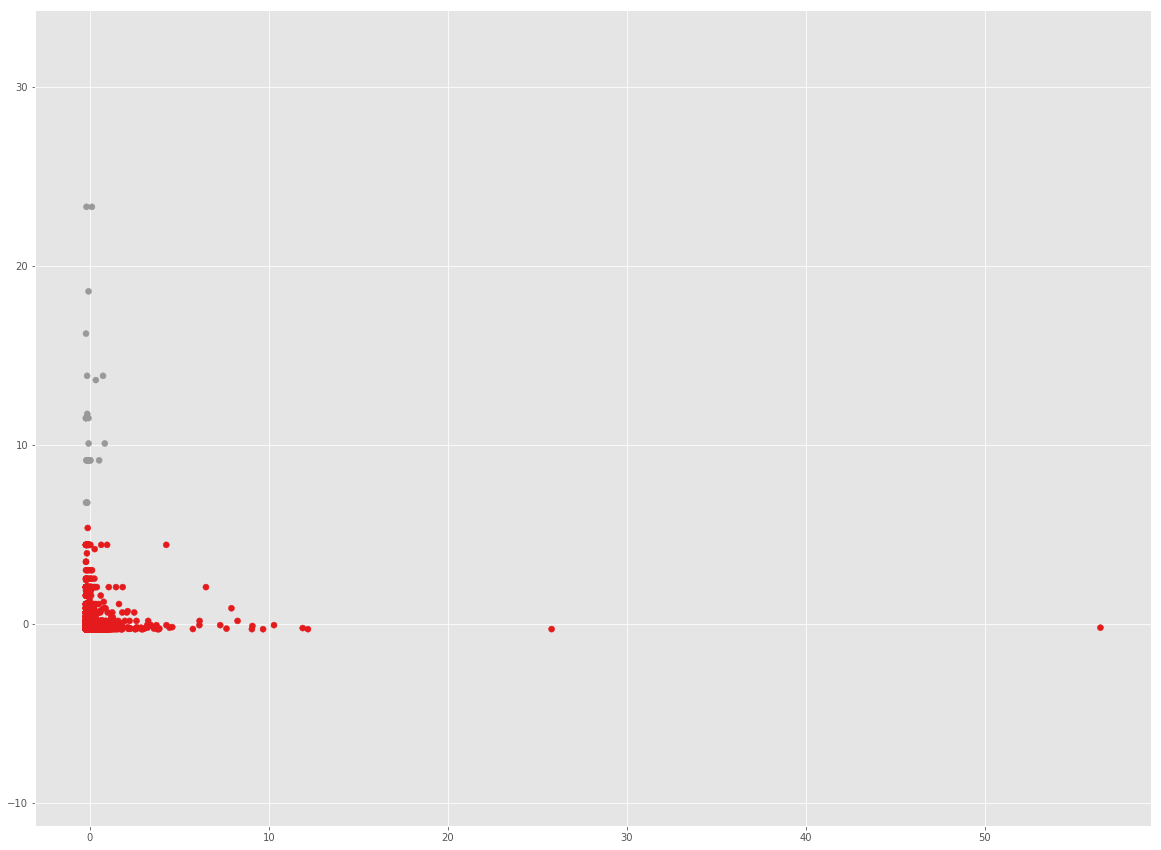

In [54]:
kmeans_cluster_assignments = kmeans.predict(data_norm)

plt.figure(figsize=(20, 15))
plt.scatter(data_norm[:, 0], data_norm[:, 1],
            c=kmeans_cluster_assignments, cmap='Set1')
plt.axis('equal')

In [55]:
data_raw['cluster'] = kmeans.predict(data_norm)

In [56]:
data_raw.head(5)

,Unnamed: 0,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn,n_days_gt10_l30d,avg_bal_gt10_l30d,score,anomaly,cluster
0,1,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0,22,80.800000,0.068373,0,0
1,2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0,22,387.156364,0.063231,0,0
2,3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0,22,49.240000,0.080095,0,0
3,4,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0,22,191.885000,0.064993,0,0
4,5,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0,22,162.414545,0.089891,0,0


In [57]:
data_raw.groupby(['churn','anomaly','cluster']).agg({"user_id":"count"}).rename(columns={"user_id":"Count"})

Count
churn anomaly cluster       
0     0       0         5132
              1           17
      1       0          153
              1            7
1     0       0          261
              1            1
      1       0           13

In [67]:
### detecting outliers
#import seaborn as sns
#sns.boxplot(x=data_cluster['time_spent'])

In [63]:
Q1 = data_cluster.quantile(0.25)
Q3 = data_cluster.quantile(0.75)
IQR = Q3 - Q1
print(Q3)
print(Q1)
print(IQR)

###df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

time_spent               33.823829
first_deposit_amount    500.000000
Name: 0.75, dtype: float64
time_spent               2.848908
first_deposit_amount    50.000000
Name: 0.25, dtype: float64
time_spent               30.974921
first_deposit_amount    450.000000
dtype: float64


In [64]:
data_cluster = data_cluster[~((data_cluster < (Q1 - 1.5 * IQR)) |(data_cluster > (Q3 + 1.5 * IQR))).any(axis=1)]

In [65]:
data_norm = scaler.fit_transform(data_cluster)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init=1000, random_state=95865)
kmeans.fit(data_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=1000, n_jobs=None, precompute_distances='auto',
    random_state=95865, tol=0.0001, verbose=0)

(-1.1545341882899123,
 3.5097290465887476,
 -0.9746617974979592,
 3.0402106900044883)

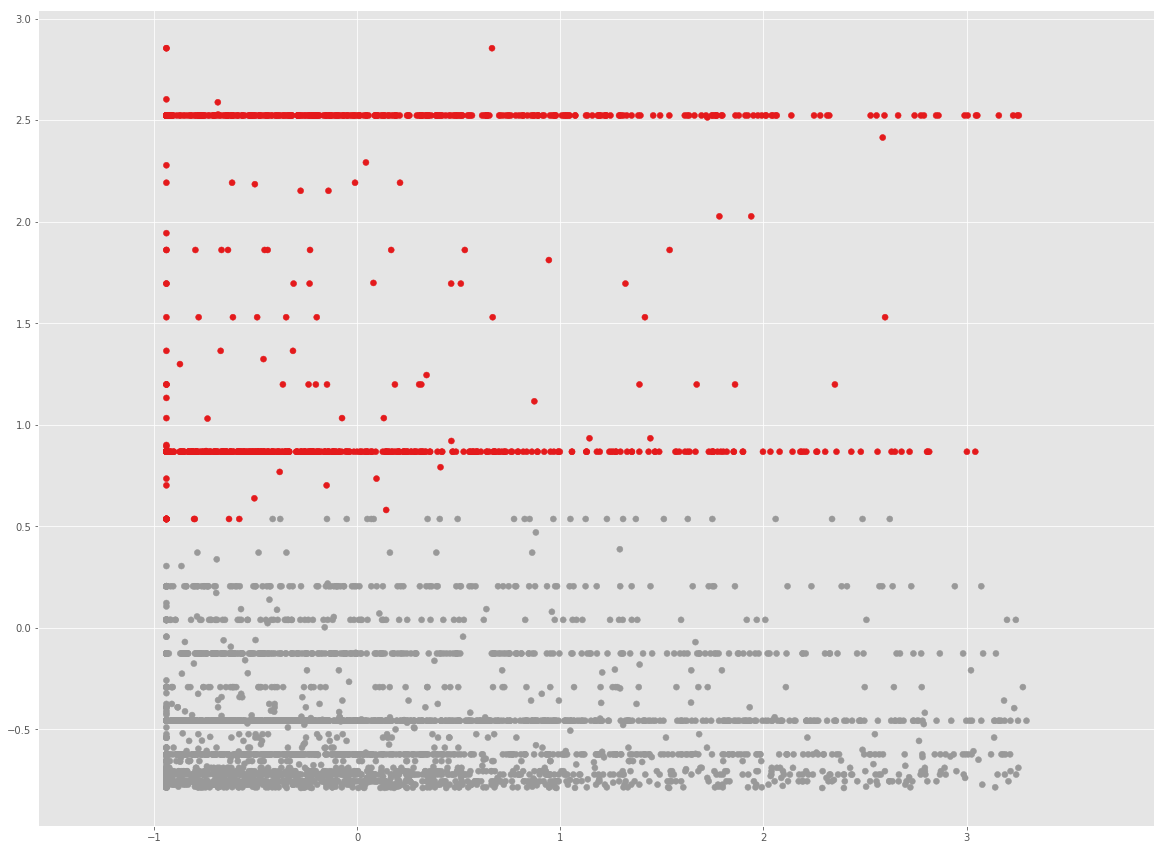

In [66]:
kmeans_cluster_assignments = kmeans.predict(data_norm)

plt.figure(figsize=(20, 15))
plt.scatter(data_norm[:, 0], data_norm[:, 1],
            c=kmeans_cluster_assignments, cmap='Set1')
plt.axis('equal')

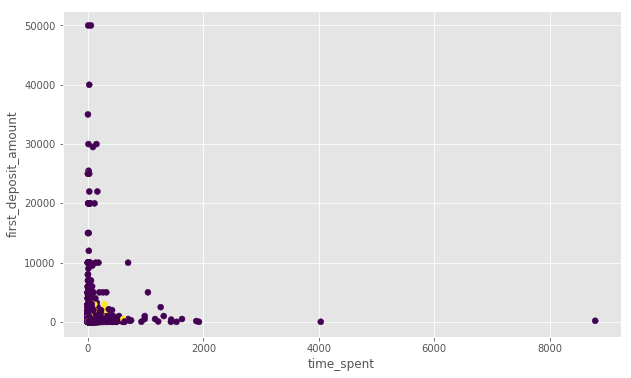

In [70]:
fig, ax=plt.subplots(figsize=(10,6))
ax.scatter(data_raw['time_spent'], data_raw['first_deposit_amount'], c=data_raw['churn'])
ax.set_xlabel('time_spent')
ax.set_ylabel('first_deposit_amount')
plt.show()

In [73]:
data_v2 = data_raw.query("time_spent < 1000 and first_deposit_amount<5000")

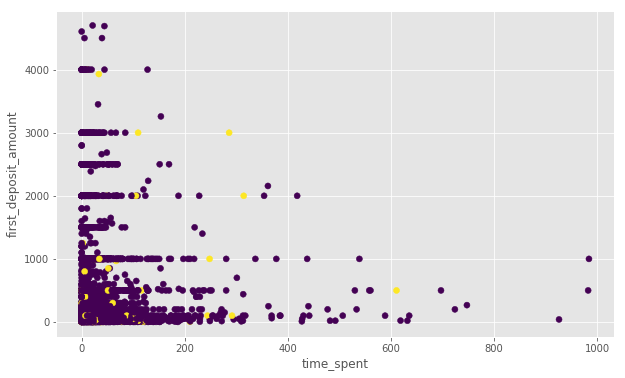

In [74]:
fig, ax=plt.subplots(figsize=(10,6))
ax.scatter(data_v2['time_spent'], data_v2['first_deposit_amount'], c=data_v2['churn'])
ax.set_xlabel('time_spent')
ax.set_ylabel('first_deposit_amount')
plt.show()